In [113]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm

from scipy.spatial import KDTree

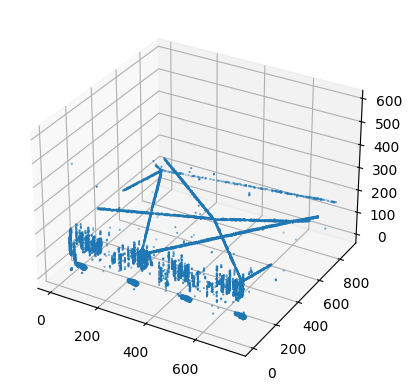

In [5]:
with open('data/2d_web.npy', 'rb') as f:
    rawData = np.load(f)
    
dsFactor = 15
order = np.arange(rawData.shape[0])
np.random.shuffle(order)
scatterPoints = rawData[order][::dsFactor,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(scatterPoints[:,2], scatterPoints[:,1], scatterPoints[:,0], s=.2)
plt.show()

In [110]:
def calculateNumNeighbors(scatterPoints, neighborThreshold, maxNeighbors=None):
    """
    Calculate the number of neighbors (points within a certain distance) each
    point has.

    This can also be achieved by summing the rows of the adjacency matrix:

    ```
    adjMat = generateAdjMat(points, distance)
    numNeighbors = np.sum(adjMat, axis=0)
    ```

    but this requires few enough points that a full adjacency matrix can
    feasibly be computed.

    Parameters
    ----------
    scatterPoints : numpy.ndarray[N, d]
        Positions of N points in d-dimensional space.

    neighborThreshold : float
        The maximum distance between two points for which they will
        not be considered to be neighbors.

    maxNeighbors : int or None
        The upper limit of neighbors for points that we care about. If
        provided, points with more neighbors than this value will be
        ignored as the calculation is performed, providing a speed-up.
    """

    numNeighbors = np.zeros(scatterPoints.shape[0])
    # If provided with a maximum number of neighbors (above which we
    # don't care about that point) we can reduce the number of calculations
    # as we go, which will speed up the computation.
    includedPoints = np.ones(scatterPoints.shape[0], dtype=bool)

    # If not provided, set the maximum number of neighbors to be 1 greater
    # than the number of points (so all points will always be included).
    if not maxNeighbors:
        maxNeighbors = scatterPoints.shape[0] + 1

    for i in tqdm.tqdm(range(scatterPoints.shape[0]), desc='Computing neighbors'):
        # Euclidian distance
        distances = np.sum((scatterPoints[i] - scatterPoints[includedPoints])**2, axis=-1)
        # -1 to account for the point itself being counted as a neighbor
        numNeighbors[i] = len(np.where(distances < neighborThreshold**2)[0]) - 1
        includedPoints[i] = numNeighbors[i] <= maxNeighbors

    return numNeighbors

In [111]:
# Calculate the number of neighbors for each point in our subset
numNeighbors = calculateNumNeighbors(scatterPoints, 20)

courseGrainingScale = .5
# Calculate the bounds of a cube enclosing all of the data
axisBounds = np.array([(np.min(scatterPoints[:,i]), np.max(scatterPoints[:,i])) for i in range(scatterPoints.shape[1])])
# Create a lattice with the selected scale for that cube
neighborDensity = np.zeros([int((axisBounds[i,1] - axisBounds[i,0])*courseGrainingScale) for i in range(scatterPoints.shape[1])])
courseGrainDim = neighborDensity.shape

# Calculate which lattice cell each scatter point falls into
latticePositions = np.array([np.floor((s - axisBounds[:,0])*courseGrainingScale) for s in scatterPoints], dtype=np.int64)

# Size in units of lattice sites (std of gaussian kernel)
courseGrainKernelSize = 1
# Our lattice could potentially be very large, so we only want to actually
# calculate the gaussian kernel within a certain radius of the source
# (since it dies off pretty quickly)
courseGrainHardCapKernelSize = 10

axisArr = [np.arange(int((axisBounds[i,1] - axisBounds[i,0])*courseGrainingScale)) for i in range(scatterPoints.shape[1])]

grids = np.meshgrid(*axisArr)

#def distance(x, y):
#    return (x - y)

for i in tqdm.tqdm(range(len(scatterPoints))):
    #neighborDensityComp = np.zeros_like(neighborDensity)
    #bounds = np.array([(latticePositions[i,j] - courseGrainHardCapKernelSize, latticePositions[i,j] + courseGrainHardCapKernelSize) for j in range(scatterPoints.shape[1])])
    #neighborDensityComp[bounds[0,0]:bounds[0,1], bounds[1,0]:bounds[1,1], bounds[2,0]:bounds[2,1]] = np.exp(np.sum([(latticePositions[i,j] - grids[j])**2 for j in range(scatterPoints.shape[1])]) / (2*courseGrainKernelSize))
    #neighborDensity += neighborDensityComp
    neighborDensity[latticePositions[i]] += numNeighbors[i]

  0%|                                                        | 5/12582 [00:00<04:02, 51.84it/s]


IndexError: index 370 is out of bounds for axis 0 with size 294

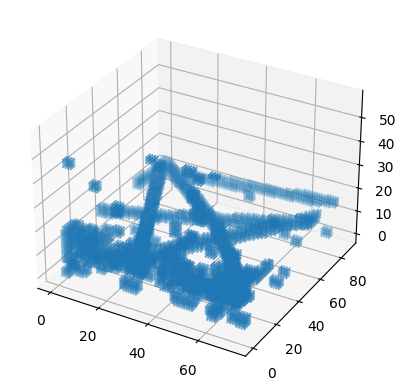

In [106]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

densityPoints = np.array(np.where(neighborDensity >= 3)).T

ax.scatter(densityPoints[:,2], densityPoints[:,1], densityPoints[:,0], s=.2)
plt.show()

In [108]:
np.subtract(latticePositions[0] - grids, axis=-1)

ValueError: operands could not be broadcast together with shapes (3,) (3,89,58,74) 

In [100]:
latticePositions[0]

array([13,  7, 47])

In [168]:
kdTree = KDTree(scatterPoints)
testPoints = np.random.uniform(0, 100, size=(1000000, 3))
numNeighbors = kdTree.query_ball_point(testPoints, 25)
numNeighbors = [len(n) for n in numNeighbors]

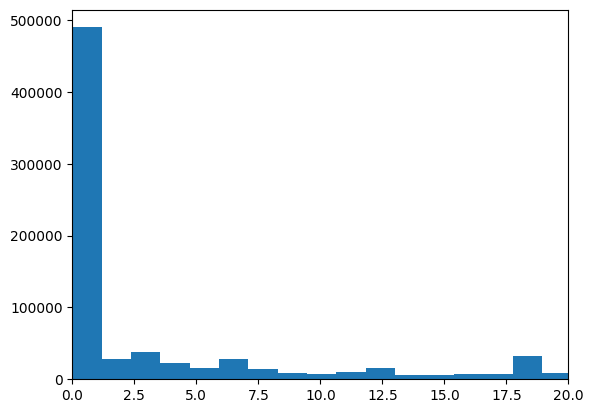

In [169]:
plt.hist(numNeighbors, bins=300)
plt.xlim([0, 20])
plt.show()

In [156]:
numNeighbors

[50,
 0,
 0,
 1,
 0,
 16,
 0,
 47,
 0,
 34,
 17,
 0,
 0,
 0,
 0,
 18,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 35,
 0,
 0,
 0,
 0,
 7,
 0,
 3,
 28,
 0,
 5,
 56,
 0,
 0,
 18,
 35,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 0,
 31,
 18,
 0,
 0,
 0,
 0,
 0,
 18,
 20,
 0,
 0,
 0,
 0,
 212,
 83,
 0,
 3,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 27,
 0,
 18,
 0,
 0,
 0,
 55,
 61,
 0,
 0,
 59,
 75,
 80,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 174,
 0,
 0,
 6,
 0,
 9,
 0,
 0,
 6,
 0,
 0,
 53,
 3,
 0,
 43,
 0,
 20,
 4,
 0,
 8,
 48,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 0,
 39,
 2,
 0,
 0,
 1,
 12,
 0,
 0,
 106,
 0,
 0,
 0,
 77,
 0,
 6,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 109,
 23,
 158,
 0,
 0,
 75,
 0,
 0,
 0,
 0,
 0,
 13,
 1,
 12,
 6,
 0,
 0,
 0,
 0,
 46,
 0,
 84,
 3,
 0,
 5,
 23,
 5,
 0,
 0,
 30,
 49,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 11,
 11,
 0,
 174,
 244,
 0,
 23,
 262,
 0,
 2,
 0,
 3,
 0,
 2,
 48,
 80,
 0,
 6,
 121,
 0,
 16,
 48,
 0,
 19,
 0,
 56,
 1,
 10,
